## Setup imports

In [34]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /home/<username>/miniconda3/envs/AI/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.15.2
Pillow version: 11.1.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.21.0+cu124
tqdm version: NOT INSTALLED or UNKNOWN VERSION.
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.1.1
pandas version: 2.2.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UN

## Setup data directory

In [35]:
data_path = "data/"
train_path = data_path + "NCT-CRC-HE-100K"
test_path = data_path + "CRC-VAL-HE-7K"

## Set deterministic training for reproducibility

In [36]:
set_determinism(seed=42)

## Train data

In [37]:
class_names = sorted(x for x in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, x)))
num_class = len(class_names)
image_files = [
    [os.path.join(train_path, class_names[i], x) for x in os.listdir(os.path.join(train_path, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 100000
Image dimensions: 224 x 224
Label names: ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
Label counts: [10407, 10566, 11512, 11557, 8896, 13536, 8763, 10446, 14317]


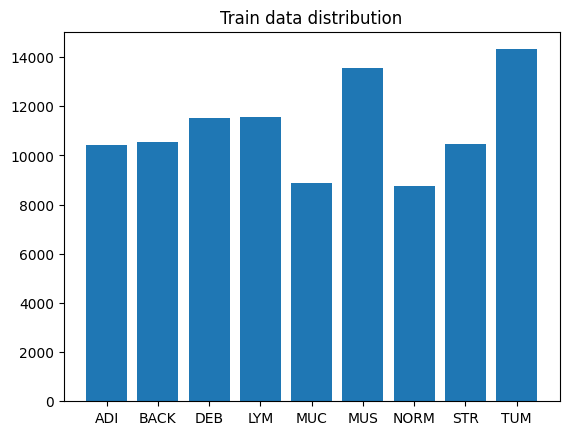

In [38]:
# Plot train data distribution
plt.figure()
plt.bar(class_names, num_each)
plt.title("Train data distribution")
plt.show()

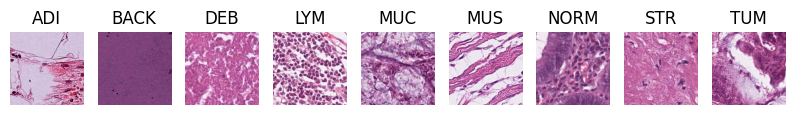

In [39]:
# Plot an image from each class
plt.figure(figsize=(10, 5))
for i in range(num_class):
    plt.subplot(1, num_class, i + 1)
    plt.imshow(PIL.Image.open(image_files[i][0]))
    plt.title(class_names[i])
    plt.axis("off")
plt.show()

## Prepare training and validation splits

In [40]:
val_frac = 0.2
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

val_split = int(val_frac * length)
val_indices = indices[:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}")

Training count: 80000, Validation count: 20000


## Define transforms, Dataset and Dataloader to pre-process data

In [41]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

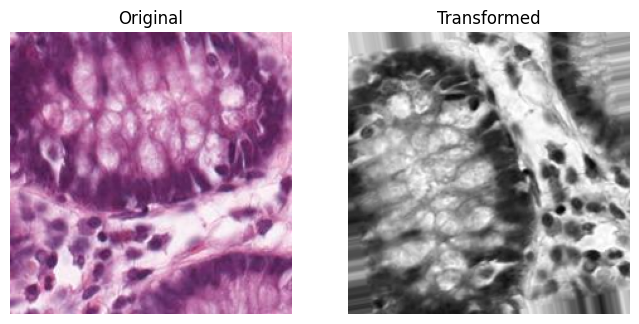

In [42]:
# Example of original and transformed image
plt.figure(figsize=(8, 8))

trans = train_transforms(train_x[0])
orig = PIL.Image.open(train_x[0])

plt.subplot(1, 2, 1)
plt.imshow(orig)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(trans[0], cmap="gray")
plt.title("Transformed")
plt.axis("off")
plt.show()

In [43]:
class TissuesDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = TissuesDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=10)
print("Number of train batches:", len(train_loader))

val_ds = TissuesDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=32, num_workers=10)
print("Number of validation batches:", len(val_loader))

Number of train batches: 2500
Number of validation batches: 625


## Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
1. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.  
And as this is just a get start tutorial, let's just train 4 epochs.  
If train 10 epochs, the model can achieve 100% accuracy on test dataset. 
1. Use DenseNet from MONAI and move to GPU device, this DenseNet can support both 2D and 3D classification tasks.
1. Use Adam optimizer.

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

Device: cuda
NVIDIA GeForce RTX 3090


## Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.  
Will save the model weights to file if got best validation accuracy.

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(data_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/2500, train_loss: 2.2550
2/2500, train_loss: 2.3307
3/2500, train_loss: 2.2400
4/2500, train_loss: 2.1752
5/2500, train_loss: 2.2357
6/2500, train_loss: 2.2196
7/2500, train_loss: 2.2028
8/2500, train_loss: 2.2326
9/2500, train_loss: 2.2390
10/2500, train_loss: 2.1162
11/2500, train_loss: 2.1523
12/2500, train_loss: 2.1771
13/2500, train_loss: 2.0988
14/2500, train_loss: 2.0542
15/2500, train_loss: 2.1290
16/2500, train_loss: 2.1767
17/2500, train_loss: 2.1197
18/2500, train_loss: 2.0398
19/2500, train_loss: 2.0443
20/2500, train_loss: 2.0396
21/2500, train_loss: 2.0949
22/2500, train_loss: 2.0765
23/2500, train_loss: 1.9939
24/2500, train_loss: 1.9738
25/2500, train_loss: 2.1030
26/2500, train_loss: 2.1127
27/2500, train_loss: 2.0904
28/2500, train_loss: 2.0433
29/2500, train_loss: 1.9909
30/2500, train_loss: 2.0623
31/2500, train_loss: 1.9988
32/2500, train_loss: 2.0028
33/2500, train_loss: 1.9294
34/2500, train_loss: 1.9561
35/2500, train_loss: 1.8785
36/2500,

## Plot the loss and metric

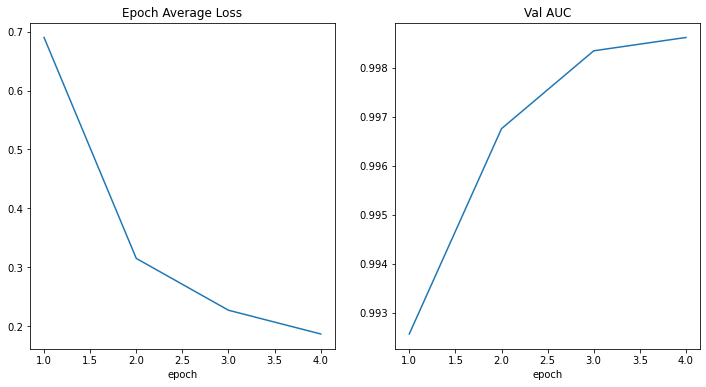

In [12]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluation with test data

In [13]:
class_names = sorted(x for x in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, x)))
num_class = len(class_names)
image_files = [
    [os.path.join(test_path, class_names[i], x) for x in os.listdir(os.path.join(test_path, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 7180
Image dimensions: 224 x 224
Label names: ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
Label counts: [1338, 847, 339, 634, 1035, 592, 741, 421, 1233]


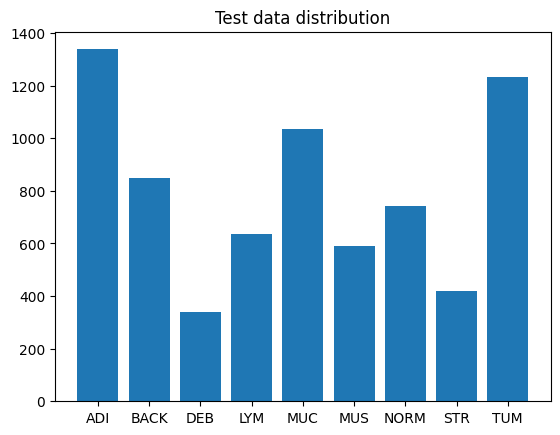

In [15]:
# Plot train data distribution
plt.figure()
plt.bar(class_names, num_each)
plt.title("Test data distribution")
plt.show()

In [16]:
test_ds = TissuesDataset(image_files_list, image_class, val_transforms)
test_loader = DataLoader(test_ds, batch_size=32, num_workers=10)

In [18]:
model.load_state_dict(torch.load(os.path.join("./models", "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [19]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

         ADI     0.9942    0.6450    0.7824      1338
        BACK     0.9139    0.9906    0.9507       847
         DEB     0.7470    0.9322    0.8294       339
         LYM     0.9744    0.8991    0.9352       634
         MUC     0.9745    0.8850    0.9276      1035
         MUS     0.4967    0.7517    0.5981       592
        NORM     0.6883    0.9001    0.7801       741
         STR     0.7530    0.6010    0.6684       421
         TUM     0.9221    0.9311    0.9266      1233

    accuracy                         0.8380      7180
   macro avg     0.8293    0.8373    0.8221      7180
weighted avg     0.8694    0.8380    0.8415      7180



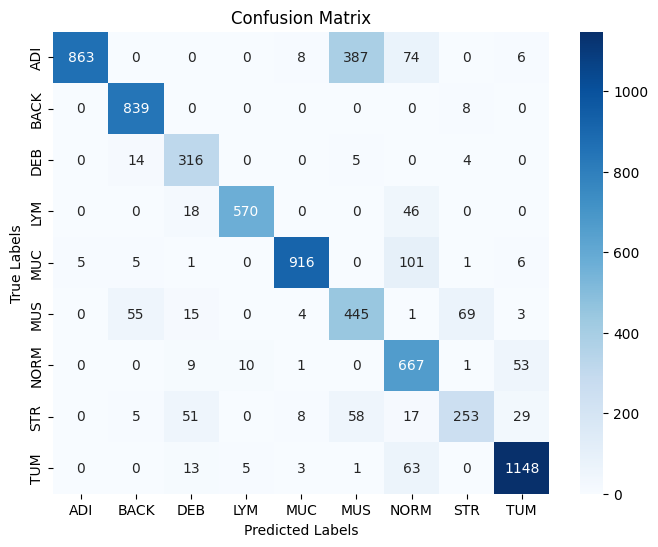

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Define class names
class_names = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", "STR", "TUM"]

# Example confusion matrix (replace with your actual values)
cm = confusion_matrix(y_true, y_pred)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()